In [1]:
import bagpipes as pipes
import numpy as np
import pandas as pd

Bagpipes: Latex distribution not found, plots may look strange.


Modifico il file con la risposta dei filtri in modo tale da avere 15 files per i 15 filtri, con due colonne riportanti lunghezze d'onda in Angstrom e trasmissione.

In [2]:
with open('COSMOS_photometry/FILTER.RES.UVISTA4.1_trimmed.R300', 'r') as f:
  lines = f.readlines()            #file con curve di trasmissione di tutti i filtri
f.close()

with open('COSMOS_photometry/FILTER.RES.UVISTA4.1_trimmed.R300.info', 'r') as f:
  markers = f.readlines()         #file con info sui filtri, le cui stringhe separano i dati nel precedente, lo uso per separare le curve dei singoli filtri 
f.close()

off = []
for mark in markers:       
 for i,line in enumerate(lines):
   if (line in mark):
    off.append(int(i))
off.append(len(lines))

filter_list = []

for i in range(len(off)-1):      #separo i filtri
   filename = 'filters/filt_%d.txt' % (i+1)
   with open(filename, 'w') as f:
    for line in lines[off[i]+1:off[i+1]]:
      f.write(line)
    filter_list.append(filename)
   f.close()

#print(lines[off[0]+1:off[1]])


In [3]:
for filename in filter_list:
  df = pd.read_csv(filename, sep="     ", names=['Number', 'Lambda', 'Transmittance'], engine='python')
  #print(df)
  df = df.drop(columns = 'Number')
  print(df.head(10))
  df.to_csv(filename, sep = ' ', header = False, index = False)

   Lambda  Transmittance
0  9540.0       0.025401
1  9550.0       0.028100
2  9560.0       0.033062
3  9570.0       0.037622
4  9580.0       0.043422
5  9590.0       0.050846
6  9600.0       0.059126
7  9610.0       0.068251
8  9620.0       0.079256
9  9630.0       0.092076
    Lambda  Transmittance
0  11430.0       0.009115
1  11440.0       0.009073
2  11450.0       0.010162
3  11460.0       0.011654
4  11470.0       0.013607
5  11480.0       0.015592
6  11490.0       0.018780
7  11500.0       0.022590
8  11510.0       0.026625
9  11520.0       0.031378
    Lambda  Transmittance
0  14610.0       0.008064
1  14620.0       0.008779
2  14630.0       0.008666
3  14640.0       0.009143
4  14650.0       0.009388
5  14660.0       0.010778
6  14670.0       0.011716
7  14680.0       0.012515
8  14690.0       0.012943
9  14700.0       0.014259
    Lambda  Transmittance
0  19340.0       0.004569
1  19350.0       0.007885
2  19360.0       0.006529
3  19370.0       0.006987
4  19380.0       0.0071

Costruisco un modello all'interno di una funzione, facendo predizioni delle magnitudini nelle bande di interesse

In [4]:
def mag_AB(age, tau, Av, massstar, filter_list):
  exp = {}                          # Tau model star formation history component
  exp["age"] = age                  # Gyr
  exp["tau"] = tau                  # Gyr
  exp["massformed"] = massstar      # log_10(M*/M_solar)
  exp["metallicity"] = 1.           # Z/Z_oldsolar

  dust = {}                         # Dust component
  dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
  dust["Av"] = Av                   # magnitudes

  model_components = {}                   # The model components dictionary
  model_components["redshift"] = 1.0      # Observed redshift  
  model_components["exponential"] = exp   
  model_components["dust"] = dust

  model = pipes.model_galaxy(model_components, filt_list=filter_list, phot_units= 'mujy')
  fluxes = model.photometry
  #fig = model.plot()
  #fig = model.sfh.plot()
  mags = [-2.5*np.log10(flux/(3631*10**6)) for flux in fluxes]
  return mags

In [5]:

print('predicted AB magnitudes',mag_AB(3, 0.75, 0.2, 9, filter_list))


predicted AB magnitudes [26.49245499363532, 26.091379047772012, 25.702559251013017, 25.395141787960736, 29.01421359208004, 28.733586289388132, 28.95469033059506, 28.343406876216225, 27.49746799871721, 26.769490468306824, 29.066524349210013, 25.143866278736738, 25.44560641285142, 25.839731746893623, 26.215386239280832]


Leggo il catalogo da file

In [6]:
c_list =pd.Index(['id', 'ra', 'dec', 'Ks_tot', 'eKs_tot', 'Ks', 'eKs', 'H', 'eH', 'J', 'eJ','Y', 'eY', 'zp','ezp','ip','eip','rp','erp', 'V','eV','gp','egp','B','eB','u','eu','ch1','ech1','ch2','ech2','ch3','ech3','ch4','ech4'])
df = pd.read_csv('COSMOS_photometry/UVISTA4.1_trimmed.cat', sep=' ', header=None, skipinitialspace= True, skiprows= 2, engine='python')
df.columns = c_list
print(df.tail(10))

            id         ra       dec    Ks_tot   eKs_tot        Ks       eKs  \
140550  262592  149.67033  2.809412  4.026997  0.633032  2.635893  0.253810   
140551  262594  149.56628  2.809309  3.167775  0.397138  2.614991  0.253437   
140552  262597  149.43350  2.809582  4.413311  0.245599  4.000869  0.257169   
140553  262598  149.78793  2.809939  5.943637  0.351228  4.923544  0.259782   
140554  262603  149.59235  2.809576  2.248833  0.264634  2.056236  0.251944   
140555  262605  149.46989  2.809795  2.429486  0.469922  1.635956  0.250824   
140556  262606  149.77904  2.809851  1.993530  0.260902  1.668055  0.251197   
140557  262611  149.65096  2.809964  4.266250  0.442675  3.078941  0.254930   
140558  262612  149.84779  2.809961  4.016919  0.581524  2.019284  0.251944   
140559  262613  149.57330  2.809791  3.098351  0.380715  2.490699  0.253437   

               H        eH         J  ...         u        eu       ch1  \
140550  3.129703  0.255676  2.282425  ...  0.276578  0.

Carico i redshift fotometrici delle galassie del catalogo

In [8]:
df_1 = pd.read_csv('COSMOS_photometry/UVISTA4.1_trimmed.zout', sep=' ', header=None, skipinitialspace= True, skiprows= 1, engine='python')
print(df_1.head(1))

   0    1      2      3         4      5         6      7    8      9      10  \
0   3 -1.0  0.549  0.547  14.05224  0.549  14.05224  0.547  1.0  0.517  0.577   

      11     12    13     14  15        16      17     18      19  
0  0.492  0.595  0.47  0.604  29  0.072602  0.5469  0.999  0.5625  


Verifico che l'ordine degli oggetti sia lo stesso in entrambi i files e salvo i redshift

In [9]:
id_file1, id_file2 = np.array(df['id']), df_1[0]
print('numero di galassie', len(id_file1))
print('numero di id coincidenti', (id_file1 == id_file2).sum())
z_photo = np.array(df_1[17])
print('redshifts:\n', z_photo)

numero di galassie 140560
numero di id coincidenti 140560
redshifts:
 [0.5469 0.7169 0.2395 ... 3.3228 0.6564 1.4636]


Carico i dati della prima galassia (id 3)

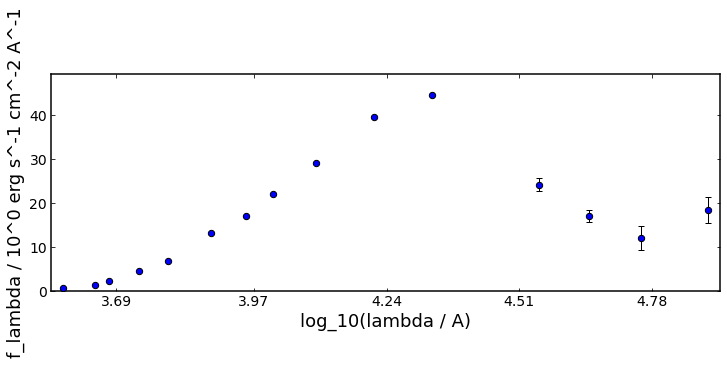

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='log_10(lambda / A)', ylabel='f_lambda / 10^0 erg s^-1 cm^-2 A^-1'>])

In [10]:
def load_data(Id):
    global df
    flux = [ 'Y', 'J', 'H', 'Ks', 'B', 'V', 'gp', 'rp', 'ip', 'zp', 'u', 'ch1', 'ch2', 'ch3', 'ch4']
    flux_err = [ 'eY', 'eJ', 'eH', 'eKs', 'eB', 'eV', 'egp', 'erp', 'eip', 'ezp', 'eu', 'ech1', 'ech2', 'ech3', 'ech4']
    photometry=np.column_stack(([df.loc[df['id'] == int(Id), flux[l]] for l in range(15)],[df.loc[df['id'] == int(Id), flux_err[l]] for l in range(15)]))
    return photometry

galaxy = pipes.galaxy(ID= '5', load_data= load_data, spectrum_exists = False, out_units='mujy', filt_list = filter_list)
galaxy.plot()

In [12]:
print(galaxy.photometry)

[[1.02032759e+04 2.21329900e+01 1.87744900e-01]
 [1.24993110e+04 2.92422900e+01 1.96702900e-01]
 [1.63816700e+04 3.97384600e+01 2.59035700e-01]
 [2.14976583e+04 4.46623800e+01 3.37045000e-01]
 [4.42713421e+03 1.48740200e+00 2.98600200e-02]
 [5.45484985e+03 4.55925200e+00 5.30015400e-02]
 [4.72838533e+03 2.31153900e+00 2.98600200e-02]
 [6.24895357e+03 6.95439900e+00 7.35302900e-02]
 [7.64588905e+03 1.31428900e+01 8.17418100e-02]
 [9.01091189e+03 1.70560400e+01 1.27278300e-01]
 [3.81332031e+03 6.27433700e-01 5.67340400e-02]
 [3.54392858e+04 2.42728400e+01 1.54562900e+00]
 [4.48408365e+04 1.70788100e+01 1.30898900e+00]
 [5.71638984e+04 1.21351100e+01 2.71539600e+00]
 [7.82833732e+04 1.84161700e+01 2.96286100e+00]]


Faccio il fit di un singolo oggetto, specificando il modello 

In [13]:
ID = 5 #INSERIRE ID DELLO STESSO OGGETTO DI CUI SI SONO CARICATI I DATI
z = z_photo[int(np.where(id_file1 == ID)[0])]
"""
burst = {}
burst["age"] = (0., 15.)                  # Vary age from 0 to 15 Gyr
burst["metallicity"] = (0., 2.5)          # Vary metallicity from 0 to 2.5 Solar
burst["metallicity_prior"] = "Gaussian"
burst["metallicity_prior_mu"] = 1.
burst["metallicity_prior_sigma"] = .5
burst["massformed"] = (0., 13.)           # Vary log_10(mass formed) from 0 to 13
"""
exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.

exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
#exp["metallicity"] = 1.
exp["metallicity"] = (1.,1.)             # fix Z at Z_oldsolar


dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 4.)                     # Vary Av between 0 and 4 magnitudes


fit_instructions = {}
fit_instructions["exp"] = exp         # Add the exponentially decaying sfh component to the fit
#fit_instructions["redshift"] = z
fit_instructions["redshift"] = (z,z)
#fit_instructions["redshift"] = (0., 10.)  # Vary observed redshift from 0 to 10
#fit_instructions["redshift_prior"] = "Gaussian"
#fit_instructions["redshift_prior_mu"] = 0.7
#fit_instructions["redshift_prior_sigma"] = 0.
fit_instructions["dust"] = dust

fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False, use_MPI=False)


Bagpipes: fitting object 5

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************
 ln(ev)=  -73149.797670919201      +/-   1.7451333194375558E-004
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.731      2.158      3.398
exp:age                        2.231      6.560     12.466
exp:massformed                 3.136      7.541     12.595
exp:metallicity                1.000      1.000      1.000
exp:tau                        1.706      5.045      8.397
redshift                    

/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

List of quantities calculated by default

In [14]:
list(fit.posterior.samples)

['dust:Av',
 'exp:age',
 'exp:massformed',
 'exp:metallicity',
 'exp:tau',
 'redshift',
 'stellar_mass',
 'formed_mass',
 'sfr',
 'ssfr',
 'nsfr',
 'mass_weighted_age',
 'tform',
 'tquench',
 'sfh']

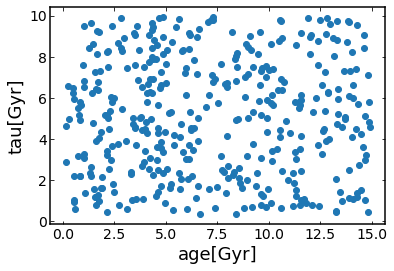

In [15]:
import matplotlib.pyplot as plt
Av_posterior = fit.posterior.samples['dust:Av']
age_posterior = fit.posterior.samples['exp:age']
massformed_posterior = fit.posterior.samples['exp:massformed']
tau_posterior = fit.posterior.samples['exp:tau']

plt.figure()
plt.xlabel('age[Gyr]')
plt.ylabel('tau[Gyr]')
plt.scatter(age_posterior, tau_posterior)
plt.show()

Diagnostic plots

In [ ]:
fig = fit.plot_corner(save = False, show=True)  ##non funziona se il range in cui variano alcuni parametri è 0 (metallicità e redshift)

/home/michela/.local/lib/python3.8/site-packages/bagpipes/plotting/plot_1d_posterior.py:55: RuntimeWarning: divide by zero encountered in log10
  samples = np.log10(samples)
/home/michela/.local/lib/python3.8/site-packages/bagpipes/plotting/general.py:177: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(range)
/home/michela/.local/lib/python3.8/site-packages/bagpipes/plotting/general.py:177: UserWarning: Attempting to set identical left == right == 0.2395 results in singular transformations; automatically expanding.
  ax.set_xlim(range)


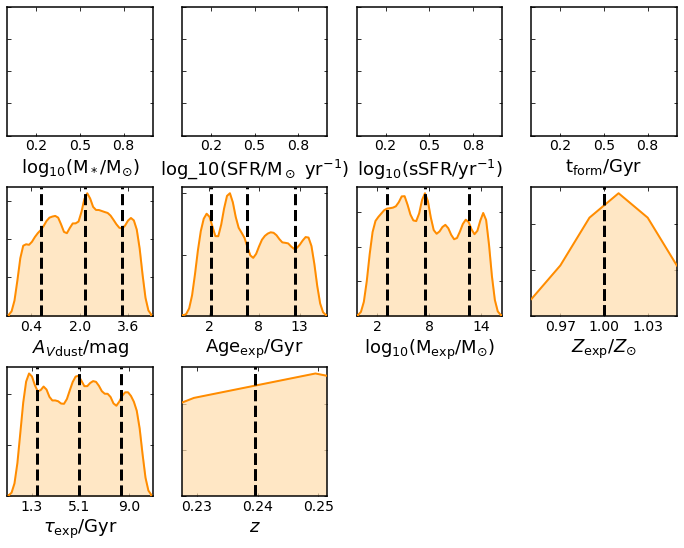

In [17]:
fig = fit.plot_1d_posterior(save=False, show=True)

Faccio un fit di tutto il catalogo con lo stesso modello

In [17]:
fit_cat = pipes.fit_catalogue(id_file1, fit_instructions, load_data, spectrum_exists= False, redshifts = z_photo, cat_filt_list = filter_list)
fit_cat.fit(verbose=False, mpi_serial=False)


Bagpipes: fitting object 3

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -71862.951594414379      +/-   1.7297054798172547E-004
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.650      1.982      3.257
exp:age                        2.544      7.243     12.265
exp:massformed                 3.456      7.939     12.321
exp:tau                        1.853      5.480      8.639




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 1 out of 140560 objects completed.

Bagpipes: fitting object 4

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2623.0608037039501      +/-   2.5711650303922483E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.859      2.106      3.347
exp:age                        2.796      7.407     12.174
exp:massformed                 2.938      7.503     13.242
exp:tau                        1.658      5.122      8.478




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 2 out of 140560 objects completed.

Bagpipes: fitting object 5

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -72501.845057952829      +/-   1.7373799883459311E-004
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.734      2.049      3.318
exp:age                        2.307      7.627     12.810
exp:massformed                 3.195      7.883     12.965
exp:tau                        2.272      5.435      8.474




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 3 out of 140560 objects completed.

Bagpipes: fitting object 11

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -713904.12238869071      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.685      2.057      3.466
exp:age                        2.570      7.285     12.700
exp:massformed                 3.298      7.941     12.992
exp:tau                        1.986      5.148      8.296




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 4 out of 140560 objects completed.

Bagpipes: fitting object 13

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -74261.681188180955      +/-   1.7583313149828386E-004
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.666      2.189      3.326
exp:age                        2.748      7.717     12.553
exp:massformed                 3.254      8.327     13.044
exp:tau                        1.877      5.360      8.458




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 5 out of 140560 objects completed.

Bagpipes: fitting object 15

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -330.23260192352382      +/-   5.1687916251847266E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.584      2.025      3.306
exp:age                        2.711      8.248     12.461
exp:massformed                 3.341      8.084     12.114
exp:tau                        2.302      5.215      8.418




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 6 out of 140560 objects completed.

Bagpipes: fitting object 16

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   468.40061977716141      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.562      1.788      3.302
exp:age                        2.660      7.884     12.811
exp:massformed                 3.194      7.986     12.498
exp:tau                        1.677      4.981      8.399




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 7 out of 140560 objects completed.

Bagpipes: fitting object 18

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3866.7416439407934      +/-   3.1202789590802928E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.650      1.985      3.364
exp:age                        2.493      8.163     12.827
exp:massformed                 2.967      7.776     12.681
exp:tau                        2.115      5.031      8.492




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 8 out of 140560 objects completed.

Bagpipes: fitting object 21

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2785.3807380338981      +/-   2.6499879180977832E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.524      1.948      3.333
exp:age                        3.006      7.585     12.739
exp:massformed                 3.356      7.756     12.753
exp:tau                        1.863      4.974      8.346




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 9 out of 140560 objects completed.

Bagpipes: fitting object 22

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -17556.542638409504      +/-   1.1138409772891511E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.763      2.097      3.489
exp:age                        3.312      7.555     12.747
exp:massformed                 3.263      7.825     12.535
exp:tau                        1.897      5.019      8.401




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 10 out of 140560 objects completed.

Bagpipes: fitting object 28

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -676.83663580130894      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.658      1.960      3.328
exp:age                        2.819      7.250     12.381
exp:massformed                 3.330      8.427     13.138
exp:tau                        2.038      5.028      8.637




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 11 out of 140560 objects completed.

Bagpipes: fitting object 35

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -8324.9859346103367      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.775      2.093      3.429
exp:age                        2.785      8.225     12.802
exp:massformed                 3.158      8.152     12.230
exp:tau                        1.577      4.744      8.278




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 12 out of 140560 objects completed.

Bagpipes: fitting object 38

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -39794.774860803147      +/-   2.5356620131069399E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.686      2.073      3.326
exp:age                        2.630      7.553     12.675
exp:massformed                 2.986      7.419     12.319
exp:tau                        1.398      4.840      8.304




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 13 out of 140560 objects completed.

Bagpipes: fitting object 41

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -352422.94633524108      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.662      2.059      3.325
exp:age                        2.418      7.455     12.719
exp:massformed                 2.849      7.079     13.103
exp:tau                        1.868      5.468      8.519




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 14 out of 140560 objects completed.

Bagpipes: fitting object 42

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4928.9024716436606      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.662      2.157      3.316
exp:age                        2.285      6.981     12.094
exp:massformed                 2.894      7.568     12.621
exp:tau                        1.690      5.204      8.426




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 15 out of 140560 objects completed.

Bagpipes: fitting object 43

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -203.23536332016212      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.659      2.080      3.465
exp:age                        2.502      7.134     12.509
exp:massformed                 3.479      8.326     12.868
exp:tau                        1.802      5.470      8.680




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 16 out of 140560 objects completed.

Bagpipes: fitting object 44

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -18457.136589626803      +/-   1.1419826850141826E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.647      1.894      3.425
exp:age                        2.840      7.403     12.119
exp:massformed                 3.183      7.604     12.408
exp:tau                        2.145      5.668      8.552




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 17 out of 140560 objects completed.

Bagpipes: fitting object 46

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -233.53314253091091      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.552      1.927      3.482
exp:age                        2.829      7.474     12.461
exp:massformed                 3.523      8.250     12.981
exp:tau                        1.911      5.484      8.523




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 18 out of 140560 objects completed.

Bagpipes: fitting object 49

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -94.824823032020504      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.573      2.052      3.384
exp:age                        2.676      7.158     12.245
exp:massformed                 2.990      7.469     12.989
exp:tau                        1.694      5.220      8.221




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 19 out of 140560 objects completed.

Bagpipes: fitting object 53

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -41941.831460879963      +/-   2.6036182151372239E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.625      1.947      3.386
exp:age                        2.534      7.249     12.305
exp:massformed                 3.362      7.791     12.583
exp:tau                        1.869      5.434      8.235




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 20 out of 140560 objects completed.

Bagpipes: fitting object 54

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -6774.3907911170618      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.591      1.979      3.256
exp:age                        2.706      7.568     12.408
exp:massformed                 3.122      7.603     12.374
exp:tau                        1.819      4.963      8.281




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 21 out of 140560 objects completed.

Bagpipes: fitting object 55

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2392.5906279264464      +/-   2.4567527784945304E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.659      2.146      3.446
exp:age                        2.910      7.439     12.977
exp:massformed                 3.430      8.270     12.672
exp:tau                        2.047      5.395      8.203




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 22 out of 140560 objects completed.

Bagpipes: fitting object 56

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -6030.1053515727917      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.509      1.870      3.385
exp:age                        2.226      6.928     11.999
exp:massformed                 3.672      8.676     12.832
exp:tau                        1.829      5.270      8.554




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 23 out of 140560 objects completed.

Bagpipes: fitting object 58

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -12386.583960795733      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.612      2.067      3.264
exp:age                        2.327      7.508     12.585
exp:massformed                 3.128      7.498     12.493
exp:tau                        1.854      5.409      8.605




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 24 out of 140560 objects completed.

Bagpipes: fitting object 60

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -6990.9417310926428      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.732      1.975      3.391
exp:age                        2.587      7.948     12.694
exp:massformed                 3.543      8.458     13.214
exp:tau                        1.997      5.487      8.541




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 25 out of 140560 objects completed.

Bagpipes: fitting object 61

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4031.1963273097786      +/-   3.1857218967462717E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.566      2.108      3.435
exp:age                        2.555      7.880     12.791
exp:massformed                 3.189      8.212     12.810
exp:tau                        1.873      5.408      8.720




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 26 out of 140560 objects completed.

Bagpipes: fitting object 62

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -81.529389660601282      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.755      2.159      3.284
exp:age                        2.399      7.498     12.310
exp:massformed                 3.019      8.544     13.385
exp:tau                        2.028      4.987      8.694




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 27 out of 140560 objects completed.

Bagpipes: fitting object 63

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1878.7746395017207      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.519      2.071      3.340
exp:age                        2.869      7.979     13.088
exp:massformed                 3.624      8.180     12.510
exp:tau                        1.961      5.070      8.354




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 28 out of 140560 objects completed.

Bagpipes: fitting object 67

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2823.0073506883955      +/-   2.6679454472965485E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.630      1.872      3.325
exp:age                        2.351      7.234     12.505
exp:massformed                 3.485      7.796     12.531
exp:tau                        1.798      5.114      8.711




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 29 out of 140560 objects completed.

Bagpipes: fitting object 70

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -718.67103235289608      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.475      2.030      3.325
exp:age                        2.731      7.469     12.623
exp:massformed                 3.120      7.624     12.598
exp:tau                        2.126      5.458      8.443




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 30 out of 140560 objects completed.

Bagpipes: fitting object 71

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1661.4584461167995      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.646      1.954      3.411
exp:age                        2.074      7.418     12.500
exp:massformed                 3.482      8.278     13.220
exp:tau                        1.926      5.295      8.216




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 31 out of 140560 objects completed.

Bagpipes: fitting object 72

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1823.6672031473533      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.594      1.984      3.160
exp:age                        2.522      7.100     12.511
exp:massformed                 3.304      8.246     12.758
exp:tau                        1.591      5.070      8.707




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 32 out of 140560 objects completed.

Bagpipes: fitting object 73

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -19189.790463360398      +/-   1.1645765321711538E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.735      2.061      3.423
exp:age                        2.813      7.508     12.398
exp:massformed                 3.103      8.603     12.712
exp:tau                        2.010      5.179      8.594




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 33 out of 140560 objects completed.

Bagpipes: fitting object 75

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   506.02847758323043      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.538      2.079      3.463
exp:age                        2.276      7.445     12.751
exp:massformed                 3.183      8.427     12.615
exp:tau                        1.827      4.873      8.607




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 34 out of 140560 objects completed.

Bagpipes: fitting object 76

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1071.5406162838647      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.589      1.863      3.320
exp:age                        2.408      7.589     12.617
exp:massformed                 3.216      7.849     12.628
exp:tau                        2.510      5.825      8.771




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 35 out of 140560 objects completed.

Bagpipes: fitting object 77

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -31706.825307209027      +/-   1.4971471846546623E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.808      2.134      3.359
exp:age                        2.673      7.377     12.454
exp:massformed                 2.930      7.447     12.519
exp:tau                        1.915      5.188      8.484




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 36 out of 140560 objects completed.

Bagpipes: fitting object 80

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -838.73305716958009      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.578      1.947      3.337
exp:age                        2.405      7.069     12.338
exp:massformed                 2.942      7.942     12.671
exp:tau                        2.109      5.469      8.504




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 37 out of 140560 objects completed.

Bagpipes: fitting object 81

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -12349.570141831795      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.652      1.870      3.166
exp:age                        2.642      7.182     12.091
exp:massformed                 3.912      8.505     12.544
exp:tau                        2.128      5.370      8.495




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 38 out of 140560 objects completed.

Bagpipes: fitting object 84

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -217785.47627304241      +/-   1.8764763008351579E-004
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.755      2.200      3.359
exp:age                        3.027      7.870     12.189
exp:massformed                 3.049      7.684     12.752
exp:tau                        1.677      5.245      8.370




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 39 out of 140560 objects completed.

Bagpipes: fitting object 85

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4992.5064092518487      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.576      2.008      3.388
exp:age                        2.572      6.956     12.570
exp:massformed                 3.262      7.770     13.036
exp:tau                        1.750      4.766      8.133




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 40 out of 140560 objects completed.

Bagpipes: fitting object 93

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4367.4540793448068      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.635      1.953      3.274
exp:age                        2.474      7.144     12.209
exp:massformed                 3.452      8.309     13.181
exp:tau                        2.192      5.452      8.618




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 41 out of 140560 objects completed.

Bagpipes: fitting object 94

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2305.8150878059078      +/-   2.4088537102346590E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.687      1.899      3.312
exp:age                        2.806      7.985     12.604
exp:massformed                 3.426      8.015     12.953
exp:tau                        1.996      5.276      8.297




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 42 out of 140560 objects completed.

Bagpipes: fitting object 97

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -8793.2915684066247      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.695      2.014      3.357
exp:age                        2.557      7.936     12.932
exp:massformed                 3.035      8.322     12.774
exp:tau                        2.075      5.111      8.400




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 43 out of 140560 objects completed.

Bagpipes: fitting object 98

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -229.28347919959501      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.678      2.006      3.279
exp:age                        2.395      6.939     12.227
exp:massformed                 3.161      7.981     12.747
exp:tau                        2.073      5.159      8.535




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 44 out of 140560 objects completed.

Bagpipes: fitting object 99

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1595.2267589624557      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.764      2.191      3.385
exp:age                        2.471      7.088     12.609
exp:massformed                 2.985      7.354     12.643
exp:tau                        1.988      5.873      8.555




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 45 out of 140560 objects completed.

Bagpipes: fitting object 100

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   470.06865362895985      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.633      1.932      3.363
exp:age                        2.490      7.783     12.689
exp:massformed                 3.429      7.830     12.139
exp:tau                        1.939      5.158      8.567




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 46 out of 140560 objects completed.

Bagpipes: fitting object 101

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   381.54791485452211      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.615      2.009      3.490
exp:age                        2.322      7.365     12.546
exp:massformed                 2.735      7.962     12.394
exp:tau                        2.000      4.979      8.227




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 47 out of 140560 objects completed.

Bagpipes: fitting object 102

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1208.3477499062099      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.649      2.068      3.392
exp:age                        2.338      7.326     12.017
exp:massformed                 2.986      7.955     12.786
exp:tau                        2.046      5.481      8.883




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 48 out of 140560 objects completed.

Bagpipes: fitting object 104

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   212.92309605308324      +/-   3.1573587985394069E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.590      2.035      3.340
exp:age                        2.754      8.022     12.600
exp:massformed                 3.213      7.900     12.744
exp:tau                        1.855      5.352      8.432




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 49 out of 140560 objects completed.

Bagpipes: fitting object 105

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3442.4827296390022      +/-   2.9436730068303396E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.638      1.819      3.364
exp:age                        1.860      7.739     12.664
exp:massformed                 3.407      8.176     12.767
exp:tau                        1.629      5.177      8.528




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 50 out of 140560 objects completed.

Bagpipes: fitting object 106

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1475.6642718797091      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.651      1.987      3.286
exp:age                        2.354      7.300     12.119
exp:massformed                 3.217      7.861     12.897
exp:tau                        2.109      5.334      8.479




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 51 out of 140560 objects completed.

Bagpipes: fitting object 107

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1524.1820732499334      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.751      2.068      3.389
exp:age                        3.086      8.176     13.066
exp:massformed                 3.258      8.411     12.729
exp:tau                        1.741      5.058      8.280




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 52 out of 140560 objects completed.

Bagpipes: fitting object 108

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -16104.222850116666      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.668      2.080      3.355
exp:age                        2.610      7.513     12.716
exp:massformed                 3.147      8.179     12.576
exp:tau                        1.921      4.850      8.302




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 53 out of 140560 objects completed.

Bagpipes: fitting object 111

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   488.44560626875489      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.635      2.025      3.359
exp:age                        2.799      7.720     12.803
exp:massformed                 3.815      8.335     12.970
exp:tau                        1.871      5.219      8.390




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 54 out of 140560 objects completed.

Bagpipes: fitting object 112

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2935.7860077972718      +/-   2.7200623887923548E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.862      1.975      3.506
exp:age                        3.524      8.193     12.205
exp:massformed                 3.309      7.891     12.963
exp:tau                        1.819      5.181      8.492




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 55 out of 140560 objects completed.

Bagpipes: fitting object 113

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -15835.378920730285      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.768      2.086      3.289
exp:age                        2.349      6.965     12.479
exp:massformed                 3.292      8.078     12.836
exp:tau                        1.964      4.967      8.176




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 56 out of 140560 objects completed.

Bagpipes: fitting object 114

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -10223.390216453254      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.662      1.965      3.293
exp:age                        1.946      7.010     13.219
exp:massformed                 2.857      7.799     12.600
exp:tau                        2.212      5.367      8.664




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 57 out of 140560 objects completed.

Bagpipes: fitting object 115

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3936.5707631017094      +/-   3.1500138406589020E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.739      1.976      3.309
exp:age                        2.758      7.679     12.789
exp:massformed                 3.266      8.012     12.648
exp:tau                        1.614      5.247      8.620




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 58 out of 140560 objects completed.

Bagpipes: fitting object 117

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -504.74381670893786      +/-   6.4052117500351370E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.598      1.896      3.327
exp:age                        2.712      7.036     12.242
exp:massformed                 3.476      8.581     13.114
exp:tau                        1.758      5.153      8.653




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 59 out of 140560 objects completed.

Bagpipes: fitting object 118

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -649.97678699701191      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.700      2.160      3.338
exp:age                        2.001      7.649     12.476
exp:massformed                 3.075      7.946     12.632
exp:tau                        1.734      4.928      8.585




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 60 out of 140560 objects completed.

Bagpipes: fitting object 120

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1262.4670168734099      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.730      2.183      3.405
exp:age                        2.152      7.682     12.815
exp:massformed                 3.245      8.252     12.741
exp:tau                        1.803      5.356      8.560




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 61 out of 140560 objects completed.

Bagpipes: fitting object 121

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   559.96953051293724      +/-   4.2214229606689867E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.730      2.125      3.405
exp:age                        2.393      7.336     12.404
exp:massformed                 3.243      8.420     12.599
exp:tau                        1.872      4.954      8.417




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 62 out of 140560 objects completed.

Bagpipes: fitting object 123

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   91.412932676188802      +/-   2.1490760299348769E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.622      1.941      3.224
exp:age                        3.003      7.368     12.718
exp:massformed                 4.086      8.283     13.125
exp:tau                        1.762      4.973      8.061




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 63 out of 140560 objects completed.

Bagpipes: fitting object 125

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2436.4818116369679      +/-   2.4772596755715443E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.674      2.140      3.460
exp:age                        2.888      8.317     13.020
exp:massformed                 2.954      8.044     12.695
exp:tau                        2.149      5.258      8.083




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 64 out of 140560 objects completed.

Bagpipes: fitting object 127

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   563.14094240012992      +/-   4.2749455158808488E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.625      2.121      3.512
exp:age                        1.888      7.227     12.672
exp:massformed                 3.495      8.111     12.828
exp:tau                        1.714      4.985      8.233




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 65 out of 140560 objects completed.

Bagpipes: fitting object 128

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -13050.740958097625      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.697      1.979      3.287
exp:age                        2.324      8.551     13.086
exp:massformed                 3.385      8.092     12.706
exp:tau                        2.210      5.409      8.474




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 66 out of 140560 objects completed.

Bagpipes: fitting object 134

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   631.40830577995894      +/-   4.5173872283688583E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.645      2.015      3.431
exp:age                        3.168      7.962     12.869
exp:massformed                 3.434      8.305     12.467
exp:tau                        1.905      5.577      8.432




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 67 out of 140560 objects completed.

Bagpipes: fitting object 136

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -12997.965845415352      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.564      1.940      3.295
exp:age                        2.586      6.972     12.796
exp:massformed                 3.489      8.535     12.839
exp:tau                        1.902      5.251      8.645




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 68 out of 140560 objects completed.

Bagpipes: fitting object 137

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -34198.202759306681      +/-   2.3509957893655276E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.643      2.197      3.503
exp:age                        2.731      7.870     12.194
exp:massformed                 3.434      7.575     12.852
exp:tau                        2.060      5.266      8.480




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 69 out of 140560 objects completed.

Bagpipes: fitting object 138

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -61551.148483969009      +/-   3.1542264410841553E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.706      2.091      3.348
exp:age                        2.269      7.432     12.127
exp:massformed                 3.180      8.132     12.629
exp:tau                        1.932      4.925      8.287




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 70 out of 140560 objects completed.

Bagpipes: fitting object 139

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4301.1879080464214      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.615      2.000      3.334
exp:age                        2.043      7.448     12.745
exp:massformed                 3.432      8.033     12.559
exp:tau                        1.736      4.744      8.578




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 71 out of 140560 objects completed.

Bagpipes: fitting object 140

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -17220.028921787973      +/-   1.1033809894108390E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.609      1.873      3.198
exp:age                        2.619      7.804     12.874
exp:massformed                 3.623      8.131     12.813
exp:tau                        2.178      5.155      8.410




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 72 out of 140560 objects completed.

Bagpipes: fitting object 144

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   345.11717882993867      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.576      1.907      3.410
exp:age                        2.945      7.956     12.665
exp:massformed                 3.046      8.104     13.026
exp:tau                        2.065      5.346      8.528




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 73 out of 140560 objects completed.

Bagpipes: fitting object 146

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1045.2806345488896      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.555      2.032      3.411
exp:age                        2.511      7.759     12.912
exp:massformed                 3.699      7.696     12.589
exp:tau                        1.768      4.717      8.402




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 74 out of 140560 objects completed.

Bagpipes: fitting object 147

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -736.86422280019883      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.742      2.116      3.332
exp:age                        3.303      7.487     12.081
exp:massformed                 3.260      7.737     13.075
exp:tau                        1.594      4.706      8.237




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 75 out of 140560 objects completed.

Bagpipes: fitting object 148

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -317.96111461533860      +/-   5.0702501101819847E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.715      2.015      3.350
exp:age                        1.892      6.825     12.221
exp:massformed                 3.236      8.077     12.589
exp:tau                        1.993      4.927      8.171




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 76 out of 140560 objects completed.

Bagpipes: fitting object 150

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1018.9526300243265      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.669      1.872      3.307
exp:age                        2.190      7.048     12.548
exp:massformed                 3.486      8.306     12.690
exp:tau                        2.016      5.286      8.451




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 77 out of 140560 objects completed.

Bagpipes: fitting object 153

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1699.5905058949454      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.585      1.905      3.162
exp:age                        2.428      7.484     12.681
exp:massformed                 3.017      7.751     12.511
exp:tau                        1.676      5.188      8.546




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 78 out of 140560 objects completed.

Bagpipes: fitting object 157

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -9212.7319792976868      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.679      2.097      3.411
exp:age                        2.820      7.697     12.468
exp:massformed                 3.452      8.600     13.059
exp:tau                        1.589      4.760      8.344




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 79 out of 140560 objects completed.

Bagpipes: fitting object 158

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -467.22440095336151      +/-   6.1574800348973079E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.483      1.856      3.252
exp:age                        2.426      7.476     12.649
exp:massformed                 2.822      7.932     13.216
exp:tau                        1.866      5.277      8.593




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 80 out of 140560 objects completed.

Bagpipes: fitting object 160

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -16950.051225269552      +/-   1.0943594579911082E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.650      1.892      3.354
exp:age                        2.423      7.788     12.800
exp:massformed                 3.399      8.448     13.247
exp:tau                        2.114      5.369      8.484




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 81 out of 140560 objects completed.

Bagpipes: fitting object 163

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -359.00798280584991      +/-   5.3934793595617388E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.736      2.105      3.456
exp:age                        2.515      7.159     12.408
exp:massformed                 3.415      8.119     12.618
exp:tau                        2.094      5.244      8.211




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 82 out of 140560 objects completed.

Bagpipes: fitting object 166

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   162.77713415118538      +/-   2.7676073947534322E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.618      1.907      3.391
exp:age                        2.743      7.838     12.534
exp:massformed                 3.220      7.633     12.501
exp:tau                        1.684      5.092      8.611




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 83 out of 140560 objects completed.

Bagpipes: fitting object 170

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   48.785906637300414      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.621      2.093      3.380
exp:age                        2.475      7.312     12.927
exp:massformed                 2.786      7.318     12.556
exp:tau                        1.548      5.108      8.261




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 84 out of 140560 objects completed.

Bagpipes: fitting object 171

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   364.95837592004602      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.610      1.863      3.218
exp:age                        2.272      6.629     12.274
exp:massformed                 3.406      7.980     12.932
exp:tau                        1.631      5.133      8.492




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 85 out of 140560 objects completed.

Bagpipes: fitting object 175

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -25063.659469013233      +/-   1.3309139270339592E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.684      2.281      3.298
exp:age                        2.371      7.586     12.477
exp:massformed                 3.228      7.142     12.633
exp:tau                        1.814      4.914      8.504




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 86 out of 140560 objects completed.

Bagpipes: fitting object 176

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -203.51465111458148      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.603      1.856      3.413
exp:age                        3.072      6.917     12.166
exp:massformed                 3.328      8.275     12.759
exp:tau                        1.747      5.041      8.330




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 87 out of 140560 objects completed.

Bagpipes: fitting object 177

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3328.5845657772961      +/-   2.8951909341552503E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.734      1.981      3.327
exp:age                        2.284      7.312     12.523
exp:massformed                 3.245      8.377     13.125
exp:tau                        1.882      5.254      8.370




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 88 out of 140560 objects completed.

Bagpipes: fitting object 178

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -5079.0601823671095      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.513      1.981      3.402
exp:age                        1.951      6.881     12.677
exp:massformed                 2.844      8.010     12.681
exp:tau                        1.674      4.850      8.346




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 89 out of 140560 objects completed.

Bagpipes: fitting object 179

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -404.42660512795362      +/-   5.7294916347016892E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.614      1.882      3.302
exp:age                        2.420      7.677     12.230
exp:massformed                 2.995      7.521     12.897
exp:tau                        1.903      5.181      8.179




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 90 out of 140560 objects completed.

Bagpipes: fitting object 183

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4232.2920596768272      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.496      1.881      3.222
exp:age                        2.694      7.961     12.892
exp:massformed                 3.656      7.737     12.764
exp:tau                        1.911      5.020      8.529




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 91 out of 140560 objects completed.

Bagpipes: fitting object 184

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -419730.01453069114      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.683      1.970      3.433
exp:age                        2.630      7.795     12.756
exp:massformed                 3.343      8.031     13.266
exp:tau                        2.077      5.363      8.410




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 92 out of 140560 objects completed.

Bagpipes: fitting object 185

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -326.81632008846941      +/-   5.1522690737186212E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.769      1.904      3.392
exp:age                        2.574      7.033     11.967
exp:massformed                 2.925      7.957     12.882
exp:tau                        2.057      5.388      8.581




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 93 out of 140560 objects completed.

Bagpipes: fitting object 188

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -13498.360879756578      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.725      2.118      3.414
exp:age                        2.563      8.175     12.778
exp:massformed                 2.802      7.516     12.613
exp:tau                        2.022      4.859      8.601




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 94 out of 140560 objects completed.

Bagpipes: fitting object 189

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -28552.823839161363      +/-   1.4203985697482544E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.728      1.978      3.335
exp:age                        2.897      8.055     13.117
exp:massformed                 3.213      7.918     12.879
exp:tau                        1.929      5.025      8.541




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 95 out of 140560 objects completed.

Bagpipes: fitting object 192

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -7079.8608343090782      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.628      2.072      3.306
exp:age                        2.036      7.103     12.116
exp:massformed                 3.199      8.356     13.023
exp:tau                        1.893      4.980      8.178




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 96 out of 140560 objects completed.

Bagpipes: fitting object 193

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2198.8659415647999      +/-   2.3546777010205058E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.582      1.807      3.205
exp:age                        2.433      7.944     12.328
exp:massformed                 3.257      7.869     12.426
exp:tau                        1.962      5.220      8.480




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 97 out of 140560 objects completed.

Bagpipes: fitting object 194

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -20693.967697007898      +/-   1.2095884121229460E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.620      2.001      3.341
exp:age                        2.931      7.491     12.436
exp:massformed                 3.591      7.840     12.554
exp:tau                        1.992      5.307      8.435




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 98 out of 140560 objects completed.

Bagpipes: fitting object 196

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2204.3915735757182      +/-   2.3546777010205058E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.724      1.965      3.364
exp:age                        2.684      7.993     12.585
exp:massformed                 3.385      8.094     12.665
exp:tau                        1.946      5.205      8.110




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 99 out of 140560 objects completed.

Bagpipes: fitting object 203

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -85899.319970021606      +/-   1.8911099588383203E-004
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.640      1.913      3.311
exp:age                        2.392      7.063     12.210
exp:massformed                 2.736      7.589     12.727
exp:tau                        1.727      4.867      8.532




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 100 out of 140560 objects completed.

Bagpipes: fitting object 205

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   292.66230098738924      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.762      2.000      3.452
exp:age                        2.636      7.489     12.451
exp:massformed                 3.342      7.738     12.807
exp:tau                        2.087      4.934      8.277




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 101 out of 140560 objects completed.

Bagpipes: fitting object 206

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -29731.299047263976      +/-   1.4493967235215862E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.641      2.015      3.423
exp:age                        2.350      7.204     12.507
exp:massformed                 2.963      7.822     12.739
exp:tau                        1.936      5.040      8.535




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 102 out of 140560 objects completed.

Bagpipes: fitting object 207

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3031.2915369459097      +/-   2.7631880177403298E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.646      1.995      3.378
exp:age                        2.242      7.388     12.805
exp:massformed                 2.688      7.774     12.669
exp:tau                        1.734      5.063      8.504




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 103 out of 140560 objects completed.

Bagpipes: fitting object 209

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   243.18822941898006      +/-   3.3759599348321665E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.740      1.929      3.358
exp:age                        2.280      8.350     12.826
exp:massformed                 2.974      7.307     12.796
exp:tau                        1.950      5.512      8.838




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 104 out of 140560 objects completed.

Bagpipes: fitting object 212

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1603.6404444464381      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.703      2.089      3.351
exp:age                        2.285      7.270     12.571
exp:massformed                 3.171      7.606     12.958
exp:tau                        1.645      5.225      8.333




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 105 out of 140560 objects completed.

Bagpipes: fitting object 215

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1853.5519482057578      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.714      2.004      3.352
exp:age                        2.580      8.007     12.890
exp:massformed                 3.150      7.989     12.648
exp:tau                        1.895      5.017      8.608




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 106 out of 140560 objects completed.

Bagpipes: fitting object 216

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   448.88987587332559      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.703      2.089      3.449
exp:age                        2.973      8.366     12.652
exp:massformed                 3.216      7.933     12.266
exp:tau                        1.934      4.741      8.106




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 107 out of 140560 objects completed.

Bagpipes: fitting object 217

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -11752.794727285431      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.520      2.009      3.356
exp:age                        2.333      7.298     12.370
exp:massformed                 3.165      7.989     12.643
exp:tau                        1.670      5.066      8.585




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 108 out of 140560 objects completed.

Bagpipes: fitting object 218

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3946.1206558360868      +/-   3.1516375127443816E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.579      1.943      3.317
exp:age                        2.331      7.917     12.327
exp:massformed                 3.492      7.819     13.159
exp:tau                        1.903      5.147      8.504




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 109 out of 140560 objects completed.

Bagpipes: fitting object 219

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   398.77068449513973      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.551      1.931      3.395
exp:age                        2.713      7.394     12.569
exp:massformed                 2.881      8.035     12.819
exp:tau                        1.858      5.043      8.423




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 110 out of 140560 objects completed.

Bagpipes: fitting object 221

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -249.28126630083190      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.646      2.023      3.447
exp:age                        2.107      7.077     12.077
exp:massformed                 3.774      8.277     13.032
exp:tau                        1.721      5.140      8.228




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 111 out of 140560 objects completed.

Bagpipes: fitting object 223

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   510.09612155470148      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.689      2.092      3.333
exp:age                        2.618      7.148     12.684
exp:massformed                 3.071      7.948     12.665
exp:tau                        1.616      4.902      8.449




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 112 out of 140560 objects completed.

Bagpipes: fitting object 224

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -32638.451281919261      +/-   1.5186496188244975E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.653      1.792      3.265
exp:age                        2.355      7.902     12.296
exp:massformed                 3.751      8.440     12.843
exp:tau                        1.936      5.236      8.455




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 113 out of 140560 objects completed.

Bagpipes: fitting object 225

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -6189.4679639481610      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.567      1.991      3.458
exp:age                        2.327      6.657     12.484
exp:massformed                 3.208      7.617     12.735
exp:tau                        1.695      4.700      8.275




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 114 out of 140560 objects completed.

Bagpipes: fitting object 228

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -97.880119953087046      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.717      2.090      3.424
exp:age                        2.888      7.969     12.644
exp:massformed                 3.388      8.079     12.885
exp:tau                        1.849      5.322      8.716




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 115 out of 140560 objects completed.

Bagpipes: fitting object 230

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -523.14368289147876      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.574      1.897      3.293
exp:age                        3.167      7.581     12.435
exp:massformed                 3.340      7.211     12.554
exp:tau                        1.732      4.905      8.453




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 116 out of 140560 objects completed.

Bagpipes: fitting object 231

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   95.660506472709130      +/-   2.6656007498500224E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.637      1.946      3.418
exp:age                        2.197      7.709     12.981
exp:massformed                 3.390      8.230     12.776
exp:tau                        1.789      4.843      8.417




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 117 out of 140560 objects completed.

Bagpipes: fitting object 232

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -63.465543664889054      +/-   6.3918860523483805E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.625      1.934      3.134
exp:age                        2.570      7.774     12.605
exp:massformed                 3.342      7.515     12.724
exp:tau                        1.647      4.789      8.215




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 118 out of 140560 objects completed.

Bagpipes: fitting object 234

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -431.96572207765064      +/-   5.9245937537141691E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.632      1.975      3.447
exp:age                        2.690      7.407     12.446
exp:massformed                 3.038      8.231     12.806
exp:tau                        1.827      5.426      8.480




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 119 out of 140560 objects completed.

Bagpipes: fitting object 237

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   121.71136764438415      +/-   2.5981062314156731E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.512      1.868      3.386
exp:age                        2.770      8.242     12.842
exp:massformed                 3.337      8.528     12.792
exp:tau                        1.526      4.814      8.610




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 120 out of 140560 objects completed.

Bagpipes: fitting object 241

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -53.580345874573695      +/-   4.1295309247228558E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.552      1.926      3.222
exp:age                        2.501      8.252     12.693
exp:massformed                 3.241      7.352     12.818
exp:tau                        1.798      4.860      8.564




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 121 out of 140560 objects completed.

Bagpipes: fitting object 242

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4272.3043113953054      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.759      1.922      3.349
exp:age                        2.773      7.701     12.326
exp:massformed                 3.215      7.640     12.558
exp:tau                        1.840      5.361      8.452




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 122 out of 140560 objects completed.

Bagpipes: fitting object 243

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -52.283345845833750      +/-   4.3800289799866286E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.665      1.880      3.348
exp:age                        2.920      7.478     12.684
exp:massformed                 3.479      8.284     12.715
exp:tau                        1.848      4.850      8.301




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 123 out of 140560 objects completed.

Bagpipes: fitting object 246

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   467.74430888776487      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.479      1.738      3.156
exp:age                        2.594      7.017     12.483
exp:massformed                 2.684      8.084     12.706
exp:tau                        1.925      5.185      8.422




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 124 out of 140560 objects completed.

Bagpipes: fitting object 247

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -226.87527431878877      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.757      2.100      3.480
exp:age                        2.845      7.439     12.811
exp:massformed                 3.479      7.943     13.006
exp:tau                        2.125      5.415      8.995




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 125 out of 140560 objects completed.

Bagpipes: fitting object 248

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -6353.8446479744898      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.557      2.124      3.447
exp:age                        2.110      7.979     12.665
exp:massformed                 3.146      8.291     12.556
exp:tau                        1.663      4.825      8.291




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 126 out of 140560 objects completed.

Bagpipes: fitting object 249

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -994.91332376907599      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.702      2.026      3.391
exp:age                        2.880      7.520     12.613
exp:massformed                 3.182      8.035     12.845
exp:tau                        2.069      5.463      8.643




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 127 out of 140560 objects completed.

Bagpipes: fitting object 250

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4376.0999206100014      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.639      1.937      3.321
exp:age                        2.203      6.895     12.504
exp:massformed                 2.712      7.641     12.937
exp:tau                        1.856      5.189      8.535




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 128 out of 140560 objects completed.

Bagpipes: fitting object 251

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -38.866520724218489      +/-   3.5262583393452262E-008
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.623      2.022      3.398
exp:age                        2.857      7.721     12.881
exp:massformed                 3.347      8.318     12.688
exp:tau                        1.567      4.922      8.636




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 129 out of 140560 objects completed.

Bagpipes: fitting object 252

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3994.0269818798452      +/-   3.1701603200139356E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.720      2.090      3.419
exp:age                        2.770      7.162     12.546
exp:massformed                 3.314      8.152     12.835
exp:tau                        2.028      5.525      8.673




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 130 out of 140560 objects completed.

Bagpipes: fitting object 253

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -5762.8760406908104      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.556      1.891      3.259
exp:age                        2.905      7.932     12.934
exp:massformed                 3.199      7.960     12.721
exp:tau                        2.165      5.294      8.375




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 131 out of 140560 objects completed.

Bagpipes: fitting object 254

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -696.42842625118305      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.656      1.849      3.200
exp:age                        2.628      7.165     12.424
exp:massformed                 3.573      8.273     12.970
exp:tau                        1.894      5.460      8.389




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 132 out of 140560 objects completed.

Bagpipes: fitting object 256

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -274.09864932222877      +/-   4.7159291374331671E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.614      2.061      3.313
exp:age                        2.953      8.252     12.236
exp:massformed                 2.920      7.620     12.246
exp:tau                        1.936      5.046      8.602




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 133 out of 140560 objects completed.

Bagpipes: fitting object 260

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1588.3884272911275      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.635      1.945      3.286
exp:age                        2.141      6.939     12.327
exp:massformed                 3.397      7.930     13.367
exp:tau                        2.025      5.672      8.723




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 134 out of 140560 objects completed.

Bagpipes: fitting object 261

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   518.31601750807113      +/-   4.1329707678221980E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.638      1.968      3.338
exp:age                        2.435      7.724     13.143
exp:massformed                 2.898      7.211     12.600
exp:tau                        1.773      5.298      8.379




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 135 out of 140560 objects completed.

Bagpipes: fitting object 262

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -286.21093301218400      +/-   4.8113908936048903E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 3.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.626      1.839      3.197
exp:age                        2.429      7.666     12.900
exp:massformed                 2.922      8.185     12.792
exp:tau                        1.992      5.047      8.495




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 136 out of 140560 objects completed.

Bagpipes: fitting object 263

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -52266.206303544575      +/-   2.9063136778925875E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.564      1.883      3.142
exp:age                        2.809      7.409     12.400
exp:massformed                 3.297      7.775     12.786
exp:tau                        2.107      5.181      8.257




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 137 out of 140560 objects completed.

Bagpipes: fitting object 265

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   214.81519046545773      +/-   3.1809005890193779E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.572      2.082      3.274
exp:age                        2.787      7.746     12.869
exp:massformed                 3.040      8.051     12.599
exp:tau                        1.745      5.464      8.522




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 138 out of 140560 objects completed.

Bagpipes: fitting object 267

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -13369.444733803522      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.727      1.866      3.313
exp:age                        2.538      8.156     12.388
exp:massformed                 2.756      8.156     12.672
exp:tau                        1.740      5.020      8.388




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 139 out of 140560 objects completed.

Bagpipes: fitting object 268

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1072.9143230094119      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.702      2.042      3.365
exp:age                        2.650      8.049     13.065
exp:massformed                 3.213      8.083     12.599
exp:tau                        1.835      5.191      7.958




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 140 out of 140560 objects completed.

Bagpipes: fitting object 271

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -812.35615953275112      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.709      1.851      3.255
exp:age                        2.230      7.138     12.986
exp:massformed                 3.324      7.892     12.585
exp:tau                        1.729      5.107      8.599




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 141 out of 140560 objects completed.

Bagpipes: fitting object 272

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   505.79912601149908      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.674      1.978      3.473
exp:age                        2.291      6.708     12.338
exp:massformed                 4.015      8.184     12.890
exp:tau                        2.139      4.857      8.470




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 142 out of 140560 objects completed.

Bagpipes: fitting object 277

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -10102.900921830751      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.648      2.024      3.255
exp:age                        2.558      6.944     12.445
exp:massformed                 3.197      7.777     12.652
exp:tau                        1.766      5.590      8.626




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 143 out of 140560 objects completed.

Bagpipes: fitting object 278

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4422.1598197729390      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.672      2.035      3.472
exp:age                        2.962      7.464     12.497
exp:massformed                 3.317      8.052     12.903
exp:tau                        2.058      5.122      8.420




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 144 out of 140560 objects completed.

Bagpipes: fitting object 284

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -5078.7203981618550      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.572      1.994      3.364
exp:age                        2.770      7.640     12.672
exp:massformed                 2.893      7.662     12.620
exp:tau                        1.633      5.532      8.536




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 145 out of 140560 objects completed.

Bagpipes: fitting object 288

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -617.49091994094420      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.722      2.083      3.357
exp:age                        2.116      6.888     12.532
exp:massformed                 3.548      7.874     12.897
exp:tau                        1.753      5.455      8.750




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 146 out of 140560 objects completed.

Bagpipes: fitting object 290

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1293.2939943078222      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.774      1.975      3.405
exp:age                        2.451      7.295     12.556
exp:massformed                 3.309      8.295     12.835
exp:tau                        2.028      5.496      8.566




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 147 out of 140560 objects completed.

Bagpipes: fitting object 291

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -828.00022089984509      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 4.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.757      2.100      3.464
exp:age                        2.410      7.926     12.153
exp:massformed                 3.248      7.905     12.870
exp:tau                        2.015      5.333      8.431




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 148 out of 140560 objects completed.

Bagpipes: fitting object 292

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3306.3068947461938      +/-   2.8851603522121132E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.563      1.935      3.374
exp:age                        2.349      6.934     11.741
exp:massformed                 3.297      7.947     12.073
exp:tau                        1.977      5.205      8.494




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 149 out of 140560 objects completed.

Bagpipes: fitting object 293

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4516.7822236790116      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.587      1.972      3.317
exp:age                        2.501      7.435     12.251
exp:massformed                 3.293      7.470     12.859
exp:tau                        1.620      5.017      8.644




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 150 out of 140560 objects completed.

Bagpipes: fitting object 294

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1756.1430568157807      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.657      1.913      3.295
exp:age                        2.209      7.072     12.463
exp:massformed                 3.113      7.577     12.500
exp:tau                        1.753      5.305      8.537




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 151 out of 140560 objects completed.

Bagpipes: fitting object 296

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3369.2246166289779      +/-   2.9131979740344865E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.588      1.987      3.330
exp:age                        2.678      7.775     12.604
exp:massformed                 3.192      7.354     12.545
exp:tau                        2.005      5.281      8.100




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 152 out of 140560 objects completed.

Bagpipes: fitting object 297

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -989.09074987543545      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.681      2.218      3.446
exp:age                        2.403      7.189     12.288
exp:massformed                 3.477      8.214     12.768
exp:tau                        1.972      5.290      8.467




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 153 out of 140560 objects completed.

Bagpipes: fitting object 298

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   620.64685795891955      +/-   4.4921502307454996E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.661      2.107      3.319
exp:age                        2.478      7.612     12.546
exp:massformed                 3.706      8.234     12.903
exp:tau                        1.868      5.454      8.283




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 154 out of 140560 objects completed.

Bagpipes: fitting object 301

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -11901.136342699712      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.594      2.128      3.399
exp:age                        2.464      7.903     12.652
exp:massformed                 3.252      8.178     12.416
exp:tau                        1.927      5.247      8.555




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 155 out of 140560 objects completed.

Bagpipes: fitting object 303

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1341.3804529094348      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.577      2.087      3.328
exp:age                        2.105      7.134     12.774
exp:massformed                 3.235      7.764     12.727
exp:tau                        1.790      4.868      8.533




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 156 out of 140560 objects completed.

Bagpipes: fitting object 304

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3903.4598851463411      +/-   3.1353629547132400E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.678      2.197      3.432
exp:age                        1.976      7.569     12.485
exp:massformed                 3.041      8.174     12.775
exp:tau                        2.001      5.458      8.525




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 157 out of 140560 objects completed.

Bagpipes: fitting object 305

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -17521.364076886348      +/-   1.1129424218460500E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.560      1.964      3.374
exp:age                        2.961      8.248     12.832
exp:massformed                 3.669      8.135     12.688
exp:tau                        1.590      4.851      7.787




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 158 out of 140560 objects completed.

Bagpipes: fitting object 306

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   410.54507910170901      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.589      1.837      3.319
exp:age                        2.381      7.504     12.841
exp:massformed                 2.649      7.833     12.384
exp:tau                        2.020      5.173      8.489




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 159 out of 140560 objects completed.

Bagpipes: fitting object 308

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1419.4946492839388      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.625      1.989      3.416
exp:age                        2.222      7.180     12.394
exp:massformed                 3.078      8.464     13.064
exp:tau                        1.725      4.891      8.383




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 160 out of 140560 objects completed.

Bagpipes: fitting object 309

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -40717.252024628964      +/-   2.5653307317163911E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.585      2.027      3.322
exp:age                        2.742      7.569     12.733
exp:massformed                 3.322      8.247     12.907
exp:tau                        2.045      5.013      8.143




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 161 out of 140560 objects completed.

Bagpipes: fitting object 312

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -325.40479875697918      +/-   5.1315410733296599E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.610      2.054      3.393
exp:age                        2.404      7.145     12.307
exp:massformed                 3.202      8.102     12.694
exp:tau                        2.060      5.125      8.315




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 162 out of 140560 objects completed.

Bagpipes: fitting object 313

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3191.1663696995383      +/-   2.8338733593184710E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.769      2.050      3.475
exp:age                        2.580      7.518     12.265
exp:massformed                 3.577      7.837     12.484
exp:tau                        1.641      4.959      8.283




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 163 out of 140560 objects completed.

Bagpipes: fitting object 314

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1258.3405400901322      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.631      1.981      3.345
exp:age                        2.598      7.363     12.701
exp:massformed                 3.386      7.754     12.790
exp:tau                        1.806      5.562      8.397




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 164 out of 140560 objects completed.

Bagpipes: fitting object 315

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3286.7876452008204      +/-   2.8768736131664956E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.575      1.755      3.246
exp:age                        2.659      7.727     13.129
exp:massformed                 3.408      8.386     13.021
exp:tau                        1.820      5.362      8.383




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 165 out of 140560 objects completed.

Bagpipes: fitting object 316

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -433.50011109603872      +/-   5.9245937537141691E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.598      1.808      3.301
exp:age                        2.045      7.046     12.467
exp:massformed                 3.445      7.919     12.544
exp:tau                        1.713      5.553      8.727




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 166 out of 140560 objects completed.

Bagpipes: fitting object 317

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2857.1657943723308      +/-   2.6830301087637327E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.648      2.043      3.291
exp:age                        2.361      7.444     12.275
exp:massformed                 3.015      7.771     13.065
exp:tau                        1.905      4.661      8.218




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 167 out of 140560 objects completed.

Bagpipes: fitting object 321

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -4026.6362622614070      +/-   3.1826871101313097E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.706      1.988      3.265
exp:age                        2.688      7.918     12.563
exp:massformed                 3.366      8.170     12.657
exp:tau                        1.743      5.095      8.362




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 168 out of 140560 objects completed.

Bagpipes: fitting object 323

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -975.77115782812939      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 3.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.508      1.758      3.444
exp:age                        2.210      7.168     12.502
exp:massformed                 3.362      8.605     12.693
exp:tau                        1.912      5.091      8.308




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 169 out of 140560 objects completed.

Bagpipes: fitting object 324

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1382.2466692354321      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.641      1.966      3.300
exp:age                        2.491      7.755     12.374
exp:massformed                 3.173      7.867     12.932
exp:tau                        1.649      4.817      8.466




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 170 out of 140560 objects completed.

Bagpipes: fitting object 325

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -28304.596201940320      +/-   1.4143347012215243E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.545      1.976      3.300
exp:age                        2.265      7.235     12.456
exp:massformed                 2.962      7.578     12.669
exp:tau                        2.018      5.457      8.688




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 171 out of 140560 objects completed.

Bagpipes: fitting object 327

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   421.85815668895827      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.582      2.056      3.334
exp:age                        2.571      7.515     12.305
exp:massformed                 3.416      8.283     12.790
exp:tau                        1.883      4.972      8.265




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 172 out of 140560 objects completed.

Bagpipes: fitting object 329

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -161.70210123653416      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.5 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.681      1.968      3.397
exp:age                        2.495      8.505     12.416
exp:massformed                 3.182      8.068     13.136
exp:tau                        1.713      4.939      8.056




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 173 out of 140560 objects completed.

Bagpipes: fitting object 331

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -2055.5755082139594      +/-   2.2758673789561699E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.611      1.744      3.266
exp:age                        2.264      7.149     13.138
exp:massformed                 3.435      8.424     12.811
exp:tau                        1.762      5.093      8.697




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 174 out of 140560 objects completed.

Bagpipes: fitting object 332

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -3541.6733263414308      +/-   2.9858536156565226E-006
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.668      1.953      3.446
exp:age                        2.404      6.782     12.774
exp:massformed                 3.656      8.310     12.861
exp:tau                        1.963      5.188      8.404




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 175 out of 140560 objects completed.

Bagpipes: fitting object 334

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -606.47611292500494      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.675      2.117      3.403
exp:age                        2.160      7.686     12.350
exp:massformed                 3.407      8.426     12.917
exp:tau                        1.768      4.677      8.078




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 176 out of 140560 objects completed.

Bagpipes: fitting object 336

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   146.01421084159441      +/-   2.6253122741633942E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.721      1.993      3.462
exp:age                        1.916      7.312     13.215
exp:massformed                 3.569      8.302     13.078
exp:tau                        1.783      5.265      8.661




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 177 out of 140560 objects completed.

Bagpipes: fitting object 339

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -291.22554511125850      +/-   4.8584184342181280E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.697      2.098      3.387
exp:age                        2.680      7.386     12.548
exp:massformed                 3.182      7.790     12.279
exp:tau                        2.057      5.512      8.622




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 178 out of 140560 objects completed.

Bagpipes: fitting object 340

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=   139.80260976398532      +/-   2.5706122699794563E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.630      2.038      3.331
exp:age                        3.041      8.125     12.920
exp:massformed                 3.488      8.297     12.816
exp:tau                        1.929      5.080      8.316




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 179 out of 140560 objects completed.

Bagpipes: fitting object 341

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -194.41429544995887      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.673      1.819      3.168
exp:age                        2.284      7.795     12.441
exp:massformed                 3.700      7.893     12.778
exp:tau                        2.032      5.015      8.412




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 180 out of 140560 objects completed.

Bagpipes: fitting object 342

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1325.7483246594386      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.634      1.958      3.229
exp:age                        1.923      7.210     12.266
exp:massformed                 2.903      8.086     12.859
exp:tau                        1.830      5.373      8.351




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 181 out of 140560 objects completed.

Bagpipes: fitting object 343

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -21888.966678182791      +/-   1.2436585905444637E-005
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.662      1.834      3.315
exp:age                        2.844      8.405     12.631
exp:massformed                 2.979      8.181     13.394
exp:tau                        1.941      5.312      8.577




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 182 out of 140560 objects completed.

Bagpipes: fitting object 344

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -397.32684740436537      +/-   5.6834208684254729E-007
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.3 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.726      2.047      3.334
exp:age                        2.184      7.573     12.700
exp:massformed                 3.421      8.166     12.739
exp:tau                        1.462      5.068      8.521




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 183 out of 140560 objects completed.

Bagpipes: fitting object 345

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -1672.8774109617316      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.7 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.554      1.909      3.303
exp:age                        2.549      6.995     12.286
exp:massformed                 3.396      8.182     12.813
exp:tau                        1.673      5.285      8.461




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 184 out of 140560 objects completed.

Bagpipes: fitting object 346

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -10447.229574575700      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 1.9 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.643      1.984      3.233
exp:age                        2.817      7.785     12.734
exp:massformed                 3.535      8.476     13.113
exp:tau                        1.745      5.004      8.349




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

Bagpipes: 185 out of 140560 objects completed.

Bagpipes: fitting object 350

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    4
 *****************************************************
 ln(ev)=  -195.83139734616972      +/-                       NaN
 Total Likelihood Evaluations:          400
 Sampling finished. Exiting MultiNest

Completed in 2.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.712      2.108      3.318
exp:age                        2.398      6.834     12.150
exp:massformed                 3.466      8.630     13.168
exp:tau                        2.002      5.515      8.489




/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:125: RuntimeWarning: divide by zero encountered in log10
  self.stellar_mass = np.log10(np.sum(self.live_frac_grid*self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:126: RuntimeWarning: divide by zero encountered in log10
  self.formed_mass = np.log10(np.sum(self.ceh.grid))
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: divide by zero encountered in log10
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:131: RuntimeWarning: invalid value encountered in double_scalars
  self.ssfr = np.log10(self.sfr) - self.stellar_mass
/home/michela/.local/lib/python3.8/site-packages/bagpipes/models/star_formation_history.py:132: RuntimeWarning: divide by zero encountered in log10
  self.nsfr = np.lo

KeyboardInterrupt: 

In [19]:
fit_cat?
